# Optimizer Notebook

 


## Julia needs to compile once 🤷  

In [1]:
#Force Notebook to work on the parent Directory
import os 
if ("Optimizer" in os.getcwd()):
    os.chdir("..")

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.include("./Optimizer/eval_NN.jl")
NN_path = "/home/freshstart/DiplomaThesisData/NeuralNetSaves_050/"


In [3]:
#----- TEST ------
RESup,RESdwn = Main.NN_eval(NN_path,"./Optimizer/RAE_var.png")


## Geometry and Image Processing


In [4]:
import Airfoil_Generation.Airfoil_Range_Creator as arg
import Airfoil_Generation.Images_Generator as ig
import numpy as np
from scipy.integrate import simps
from scipy.integrate import trapz
import matplotlib.pyplot as plt

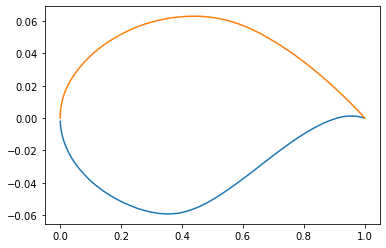

In [5]:
#--- Read Geometry ---
geom = arg.readfile("./Misc/data/RAE_2822.geom")
geom = (geom[0],geom[1][1:-1,:])
plt.plot(geom[1][:,0],geom[1][:,1])
plt.plot(geom[0][:,0],geom[0][:,1])

### Normals Calculation

In [6]:
def normals2D(geom,flip_n = False,show_norms = False):
    eta = np.ndarray((len(geom)-1,2))

    for i in range(len(geom)-1):
        xba = geom[i+1,0]-geom[i,0]
        yba = geom[i+1,1]-geom[i,1]
        if flip_n:
            yba = - yba
            xba = - xba
        nrm2 = np.sqrt(yba**2+xba**2)
        eta[i,0] = yba/nrm2
        eta[i,1] = -xba/nrm2

    if show_norms:
        fig, ax = plt.subplots()
        ax.plot(geom[0:-2,0],geom[0:-2,1])
        ax.quiver(geom[0:-2,0],geom[0:-2,1],eta[:,0],eta[:,1])
    return eta
    

def partials2D(Cp,geom,flip_norm = True,show_norms = False, show_partials = False):
    eta = normals2D(geom,flip_n=flip_norm,show_norms = show_norms)

    xClCd = np.ndarray((len(Cp),3))

    for i in range(len(Cp)):
        for j in range(len(eta)):
            if ((Cp[i,0]<= geom[j+1,0])&(Cp[i,0]>geom[j,0])):
                xClCd[i,0] = Cp[i,0]
                xClCd[i,1] = eta[j,1]*Cp[i,1]
                xClCd[i,2] = eta[j,0]*Cp[i,1]
                break
    
    if show_partials:
        fig, ax = plt.subplots()
        ax.plot(xClCd[:,0],xClCd[:,1], label = "V")
        ax.plot(xClCd[:,0],xClCd[:,2], label = "U")
        ax.legend()

    return xClCd

def calc2D(Cpup,Cpdwn,geom,show_norms = False, show_partials = False, integral = simps):
    Up = partials2D(Cpup,geom[0],flip_norm = False,show_norms=show_norms,show_partials=show_partials)
    Dn = partials2D(Cpdwn,geom[1],flip_norm = True,show_norms=show_norms,show_partials=show_partials)
    Cl  = integral(Up[:,1],x=Up[:,0])+integral(Dn[:,1],x=Dn[:,0]) #invert y-axis to match the global axis
    Cd  = integral(Up[:,2],x=Up[:,0])+integral(Dn[:,2],x=Dn[:,0])
    return Cl,Cd

Cl,Cd = calc2D(RESup,RESdwn,geom)
print("Cl = ", Cl)
print("Cd = ", Cd)


Cl =  0.7628689908109085
Cd =  -0.03404796283731905


Cl =  0.7789645967283509
Cd =  -0.03776463257599485


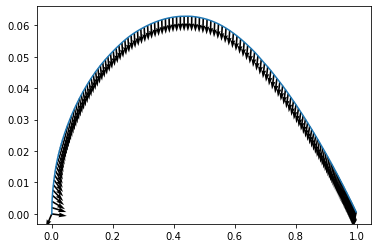

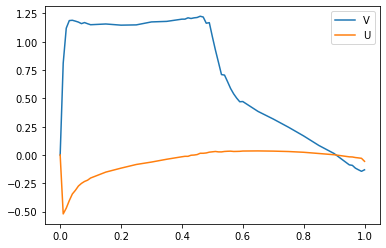

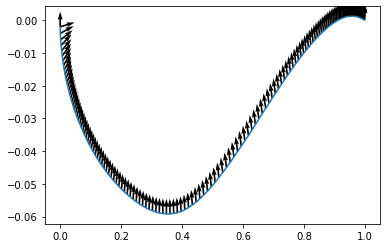

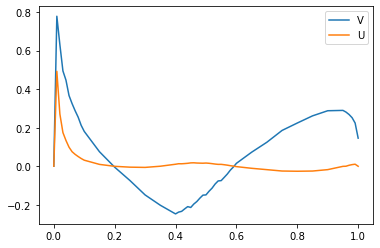

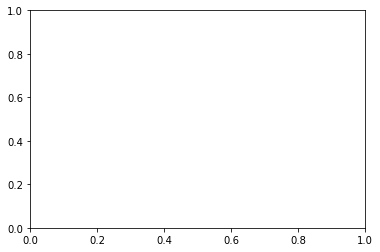

In [9]:
Cpup,Cpdwn = Main.NN_eval(NN_path,"./Optimizer/temp.png")
Cl,Cd = calc2D(Cpup,Cpdwn,geom,show_norms=True,show_partials=True)
print("Cl = ", Cl)
print("Cd = ", Cd)
fig1,ax = plt.subplots()
# ax.plot(Cpup[:,0],Cpup[:,1])
# ax.plot(Cpdwn[:,0],Cpdwn[:,1])
# ax.plot(CpupR[:,0],CpupR[:,1])
# ax.plot(CpdwnR[:,0],CpdwnR[:,1])
# ax.plot(Cpdwn[:,0],Cpdwn[:,1]-CpdwnR[:,1])
# ax.plot(Cpup[:,0],Cpup[:,1]-CpupR[:,1])

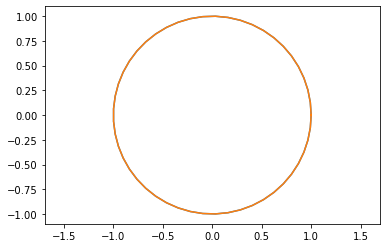

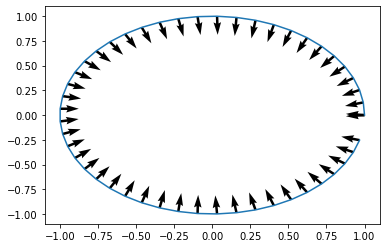

In [47]:
phi = np.linspace(0,2*3.14159)
x = np.array(np.cos(phi),ndmin = 2).reshape((len(phi),1))
y = np.array(np.sin(phi),ndmin = 2).reshape((len(phi),1))
plt.plot(x,y)
plt.axis("equal")

f = np.concatenate((x,y),axis = 1)
plt.plot(f[:,0],f[:,1])

a=partials2D(RESup,f,show_norms=True)

## Optimizer 

In [8]:
import openmdao.api as om

/opt/intel/intelpython3/lib/python3.7/site-packages/openmdao/utils/general_utils.py:128: OMDeprecationWarning:simple_warning is deprecated. Use openmdao.utils.om_warnings.issue_warning instead.
/opt/intel/intelpython3/lib/python3.7/site-packages/openmdao/utils/notebook_utils.py:157: UserWarning:Tabulate is not installed. Run `pip install openmdao[notebooks]` to install required dependencies. Using ASCII for outputs.


### Class Definition and problem set-up

In [10]:
#---- Preparing the X coordinates for use in the optimizer -------
X_UP = np.array(geom[0][:,0],ndmin=2)
X_DN = np.array(geom[1][:,0],ndmin=2)
X_UP = X_UP.reshape((X_UP.shape[1],X_UP.shape[0]))
X_DN = X_DN.reshape((X_DN.shape[1],X_DN.shape[0]))
Y_UP = np.array(geom[0][:,1],ndmin=2)
Y_DN = np.array(geom[1][:,1],ndmin=2)
Y_UP = Y_UP.reshape((Y_UP.shape[1],Y_UP.shape[0]))
Y_DN = Y_DN.reshape((Y_DN.shape[1],Y_DN.shape[0]))
##################################################################
class Airfoil(om.ExplicitComponent):
    """
    Creates the most efficient airfoil for specific Mach and Reynolds numbers
    Changing each y-coords the deformation rate is more efficient to confine
    than flat y-coordinates
    """
    def setup(self):
        self.add_input("y_up_rate",  val = 0.0)#np.zeros((len(geom[0]),1)) )
        self.add_input("y_dwn_rate", val = 0.0)#np.zeros((len(geom[1]),1)) )

        self.add_output("Cl", val = 0.0)
        self.add_output("Cd", val = 0.0)
    

    def setup_partials(self):
        self.declare_partials("*","*", method = "fd")

    def compute(self, inputs, outputs):

        r1 = inputs["y_up_rate"]
        r2 = inputs["y_dwn_rate"]
        
        y1 = (1+r1)*Y_UP
        y2 = (1+r2)*Y_DN
        
        temp_geom = (np.concatenate((X_UP,y1),axis = 1),np.concatenate((X_DN,y2),axis = 1))
        ig.image_generator(np.concatenate((temp_geom[0],temp_geom[1]),axis = 0),"./Optimizer/temp.png",32,32)
        Cpup,Cpdwn = Main.NN_eval(NN_path,"./Optimizer/temp.png")
        res = calc2D(Cpup,Cpdwn,temp_geom)
        
        outputs["Cl"] = res[0]
        outputs["Cd"] = res[1]


In [11]:
#--------- Testing --------
model = om.Group()
model.add_subsystem("airfoil",Airfoil(),promotes_inputs=["y_up_rate","y_dwn_rate"])

prob = om.Problem(model)

prob.setup()
prob.run_model()
print(prob.get_val("airfoil.Cl"))
prob.get_val("airfoil.Cd")

[0.76286899]


array([-0.03404796])

### Optimization 


In [28]:
model = om.Group()
model.add_subsystem("airfoil",Airfoil(),promotes_inputs=["y_up_rate","y_dwn_rate"])

prob = om.Problem(model)

prob.driver = om.ScipyOptimizeDriver()
# prob.driver.options["optimizer"] = "COBYLA"
prob.driver.options["optimizer"] = "SLSQP"

L_BOUND = -0.2
U_BOUND =  0.2

prob.model.add_design_var("y_up_rate",lower = L_BOUND,upper= U_BOUND)
prob.model.add_design_var("y_dwn_rate",lower = L_BOUND,upper= U_BOUND)

prob.model.add_objective("airfoil.Cl",scaler=-1)
# prob.model.add_objective("airfoil.Cd",scaler=1)

prob.setup()
prob.run_driver();
Cl_sls = prob.get_val("airfoil.Cl")
rup_sls =prob.get_val("y_up_rate")
rdwn_sls =prob.get_val("y_dwn_rate")

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.7687661037255525
            Iterations: 9
            Function evaluations: 32
            Gradient evaluations: 9
Optimization Complete
-----------------------------------


In [32]:
model = om.Group()
model.add_subsystem("airfoil",Airfoil(),promotes_inputs=["y_up_rate","y_dwn_rate"])

prob = om.Problem(model)

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options["optimizer"] = "COBYLA"
# 

L_BOUND = -0.2
U_BOUND =  0.2

prob.model.add_design_var("y_up_rate",lower = L_BOUND,upper= U_BOUND)
prob.model.add_design_var("y_dwn_rate",lower = L_BOUND,upper= U_BOUND)

prob.model.add_objective("airfoil.Cl",scaler=-1)

prob.setup()
prob.run_driver();

Cl_cob = prob.get_val("airfoil.Cl")
rup_cob =prob.get_val("y_up_rate")
rdwn_cob =prob.get_val("y_dwn_rate")
#--------------------
prob.driver.options["optimizer"] = "SLSQP"
prob.setup()
prob.model.set_input_defaults("y_up_rate",rup_cob)
prob.model.set_input_defaults("y_dwn_rate",rdwn_cob)
prob.run_driver();
#---------------------
print("------- COBYLA --------")
print("Cl = ", Cl_cob)
print("Rate up = ",rup_cob )
print("Rate dwn = ",rdwn_cob )
print("###########################")
print("-------- SLSQP ---------")
print("Cl = ", prob.get_val("airfoil.Cl"))
print("Rate up = ", prob.get_val("y_up_rate"))
print("Rate dwn = ", prob.get_val("y_dwn_rate"))
print("###########################")

Optimization Complete
   Normal return from subroutine COBYLA

   NFVALS =   48   F =-8.083765E-01    MAXCV = 0.000000E+00
   X =-4.410847E-02  -2.000000E-01

-----------------------------------


In [30]:
#---------- maximize Cl SLSQP Optimizer ------------
print("Cl = ", prob.get_val("airfoil.Cl"))
print("Cd = ", prob.get_val("airfoil.Cd"))
print("Rate up = ", prob.get_val("y_up_rate"))
print("Rate dwn = ", prob.get_val("y_dwn_rate"))

Cl =  [0.7687661]
Cd =  [-0.03442111]
Rate up =  [-0.02559725]
Rate dwn =  [-0.01235054]


In [51]:
#----- Maximize Cl COBYLA -----
print("Cl = ", prob.get_val("airfoil.Cl"))
print("Cd = ", prob.get_val("airfoil.Cd"))
print("Rate up = ", prob.get_val("y_up_rate"))
print("Rate dwn = ", prob.get_val("y_dwn_rate"))

Cl =  [0.80771982]
Cd =  [-0.03499127]
Rate up =  [-0.04532442]
Rate dwn =  [-0.19971566]


Cl =  0.7628689908109085
Cd =  -0.03404796283731905


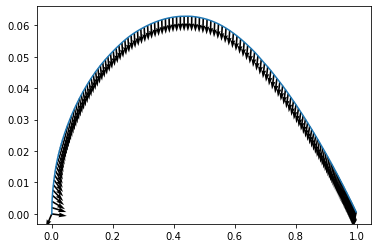

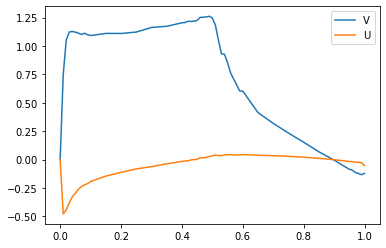

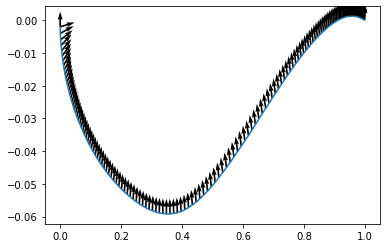

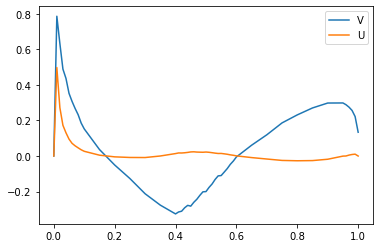

In [43]:
CpupR,CpdwnR = Main.NN_eval(NN_path,"./Optimizer/RAE_var.png")
Cl,Cd = calc2D(CpupR,CpdwnR,geom,show_norms=True,show_partials=True)
print("Cl = ", Cl)
print("Cd = ", Cd)


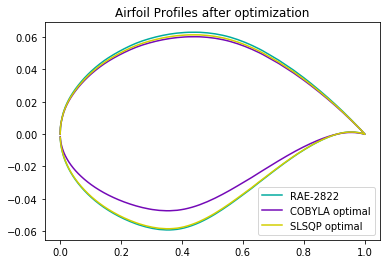

In [38]:
col = [i for i in ["#00ab9f","#7409b7","#d2cf00","#ff6f00"] ] # mah precious colors
plt.plot(X_UP,Y_UP,c = col[0],label = "RAE-2822")
plt.plot(X_DN,Y_DN,c = col[0])
plt.plot(X_UP,(1+rup_cob)*Y_UP,c = col[1],label = "COBYLA optimal")
plt.plot(X_DN,(1+rdwn_cob)*Y_DN,c = col[1])
plt.plot(X_UP,(1+rup_sls)*Y_UP,c = col[2],label = "SLSQP optimal")
plt.plot(X_DN,(1+rdwn_sls)*Y_DN,c = col[2])
plt.legend()
plt.title("Airfoil Profiles after optimization")
plt.savefig("/home/freshstart/DiplomaThesisData/images/OPT_profiles.pdf")

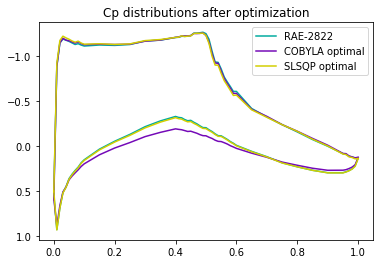

In [39]:
CpupR,CpdwnR = Main.NN_eval(NN_path,"./Optimizer/RAE_var.png")
CpupR_s,CpdwnR_s = Main.NN_eval(NN_path,"./Optimizer/temp_slsqp.png")
CpupR_c,CpdwnR_c = Main.NN_eval(NN_path,"./Optimizer/temp_cobyla.png")

plt.plot(CpupR[:,0] ,CpupR[:,1],c = col[0],label = "RAE-2822")
plt.plot(CpdwnR[:,0],CpdwnR[:,1],c = col[0])
plt.plot(CpupR[:,0] ,CpupR_c[:,1],c = col[1],label = "COBYLA optimal")
plt.plot(CpdwnR[:,0],CpdwnR_c[:,1],c = col[1])
plt.plot(CpupR[:,0] ,CpupR_s[:,1],c = col[2],label = "SLSQP optimal")
plt.plot(CpdwnR[:,0],CpdwnR_s[:,1],c = col[2])
plt.gca().invert_yaxis()
plt.legend()
plt.title("Cp distributions after optimization")
plt.savefig("/home/freshstart/DiplomaThesisData/images/OPT_CPs.pdf")